In [1]:
import numpy as np
import pandas as pd
import nltk
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quentin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
dataset = pd.read_csv('spambase.csv', header=0)
stop_words = set(nltk.corpus.stopwords.words('english')).union(set(nltk.corpus.stopwords.words('french'))).union(["{:02d}".format(i) for i in set(range(31))])

print(stop_words)

not_spam = dataset[dataset['isSpam'] == 1]['Text']
not_spam_without_stopwords = not_spam.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

{'09', 'has', 'ils', "you'd", 'eussions', "weren't", 'yours', 'aurions', 'étante', 'why', 'shouldn', 'theirs', "she's", 'of', 'other', 'should', 'where', 'étantes', 'ton', 'aurez', '21', 'while', 'fussent', 'eu', 'about', 'but', 've', 'ayants', 'est', 'tes', 'and', 'didn', 'those', 'weren', 'from', 'aies', 'eusse', "mightn't", "shan't", 'his', 'de', 'wasn', 'nor', 'sera', 'between', 'have', 'aurait', "hasn't", 'étées', 'both', '20', 'won', 'few', 'this', 'will', 'haven', 'étais', 'serais', '05', 'or', 'votre', 'eussent', "you'll", 'she', 's', 'with', 'y', '13', 'all', 'étaient', 'wouldn', 'me', 'during', 'leur', 'vos', 'à', 'was', 'seriez', 'ayante', 'fut', '28', 'themselves', 'most', 'do', '18', 'eux', 'du', 'more', 'ourselves', '04', 'avez', 'aie', 'ses', 'te', 'in', 'myself', 'qui', 'été', 'auraient', 'again', 'as', "didn't", 'were', "couldn't", '11', 'such', '12', 'sa', 'herself', 'some', 'under', 'eûtes', 'un', 'our', 'by', 'up', 'couldn', 'their', 'eut', 'furent', 'fussions', 'eu

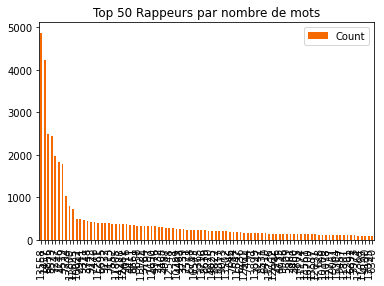

In [41]:
counter = CountVectorizer()
cv_fit = counter.fit_transform(not_spam_without_stopwords)

df = pd.DataFrame()
df["Word"] = counter.get_feature_names()
df["Count"] = cv_fit.toarray().sum(axis=0)
sorted_not_spam = df.sort_values(by='Count', ascending=False)

sorted_not_spam[sorted_not_spam['Count'] > 100].plot(kind='bar', color="#f56900", title='Top 50 Rappeurs par nombre de mots')

In [43]:
sorted_not_spam[sorted_not_spam['Count'] > 100].head

<bound method NDFrame.head of            Word  Count
13558  websites   4872
1457         50   4244
6856         gt   2488
8573         lt   2436
7247      https   1963
...         ...    ...
17364        по    103
11699   sharing    103
4190     casual    102
13095       usp    101
6340        for    101

[94 rows x 2 columns]>